# Import Libraries

In [1]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from preprocess_data import preprocess_data
from rois import rois_func, portfolio_weights

import os
import decimal
from functools import partial
from multiprocessing import Pool
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow_addons.metrics import RSquare
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

c:\Users\brarn\anaconda3\envs\tensorflow\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\brarn\anaconda3\envs\tensorflow\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an is

# Visualise Model Loss/R-squared Against Hyperparameters

In [2]:
root_folder = "results"
overview_folder = "overview"
model_results_path = f"{root_folder}/{overview_folder}/model results.csv"

# Read model results
model_results = pd.read_csv(model_results_path)

# Add a column for the number of features used to train each model and sort df on this column
model_results['feature_count'] = model_results['features'].apply(lambda x: x.count(' ') + 1 if x != '[]' else 0)
model_results = model_results.sort_values(by='feature_count')

# Drop 'feature_count' as we only needed it for sorting
model_results.drop(columns=['feature_count'], inplace=True)

# Replace spaces with commas in the "features" column for readability
model_results['features'] = model_results['features'].apply(lambda x: x.replace(' ', ', ') if x != '[]' else x)

# Create a new column which details whether the models used the chosen economic indicators or not
def economic_indicators_used(features):
    if features == '[]':
        return "no economic indicators used"
    else:
        return "chosen economic indicators used"
model_results['economic indicators used'] = model_results['features'].apply(economic_indicators_used)

# Round loss and R-squared values
model_results["val_loss"] = model_results["val_loss"].round(3)
model_results["val_r2"] = model_results["val_r2"].round(3)

# Create hover text to show when hovering cursor over a point on the plot
hover_text = model_results.apply(lambda row: '<br>'.join([f"{col}: {row[col]}" for col in model_results.columns.drop(["features", 'economic indicators used'])]), axis=1)

# Modify the order of the columns
model_results = model_results[["features", "years", "lines", "layers", "neurons per layer", "total neurons", "batch size", "technique", "model name", "economic indicators used", "val_loss", "val_r2"]]

# Identify the columns that can be used as x-axis variables for the plot
x_axis_options = model_results.columns.drop(['val_loss', 'val_r2', 'features', 'model name'])
model_results.head()

,features,years,lines,layers,neurons per layer,total neurons,batch size,technique,model name,economic indicators used,val_loss,val_r2
101,[],3,50,6,32,192,1024,base,102,no economic indicators used,25.720,0.777
73,[],2,20,4,16,64,1024,base,74,no economic indicators used,17.525,0.897
72,[],2,20,2,32,64,1024,base,73,no economic indicators used,17.286,0.900
71,[],2,20,2,16,32,1024,base,72,no economic indicators used,18.444,0.894
70,[],4,5,6,32,192,1024,base,71,no economic indicators used,19.304,0.899


In [3]:
def plot_model_performance_against_hyperparameters(performance_column, metric, x_dropdown_coordinate, y_dropdown_coordinate, title, yaxis_title):
    # Plot the performance (validation loss/ R-squared) against hyperparameters
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    initial_column = "economic indicators used"
    fig.add_trace(go.Scatter(x=model_results[initial_column], y=model_results[performance_column], mode='markers', name=metric,
                            hoverinfo="text", text=hover_text), secondary_y=False)

    # Rename hyperparameters for readability in the plot
    column_label_mapping = {
        'features': 'economic indicators',
        'years': 'previous number of years considered for the predictions',
        'lines': 'data granularity (lines)',
        'layers': 'layers',
        'neurons per layer': 'neurons per layer',
        'total neurons': 'total neurons',
        'batch size': 'batch size',
        'technique': 'technique used',
        'economic indicators used':'economic indicators used'
    }

    # Updating the layout with a dropdown menu which changes the x-axis variable 
    fig.update_layout(
        updatemenus=[
            dict(
                buttons=list([
                    dict(
                        args=[
                            {"x": [model_results[column]]},  # Update the x data
                            {"xaxis.title.text": column_label_mapping[column]}  # Update the x-axis title
                        ],
                        label=column_label_mapping[column],
                        method="update"
                    ) for column in x_axis_options
                ]),
                direction="down",
                showactive=True,
                x=x_dropdown_coordinate,
                xanchor="left",
                y=y_dropdown_coordinate,  
                yanchor="top"
            ),
        ],
        title=title,
        yaxis_title=yaxis_title,
        xaxis_title=column_label_mapping.get(initial_column, initial_column),
        autosize=False,
        width=920,
        height=600
    )

    # Save the figure as an HTML file
    html_file_path = f"{root_folder}/{overview_folder}/results ({metric}).html"
    fig.write_html(html_file_path)
    print("Plot saved.")
    return fig

In [4]:
loss_plot = plot_model_performance_against_hyperparameters("val_loss", "Loss", 0.32, 1.17, "Validation Loss of Models Against: ", "Validation Loss")
r_squared_plot = plot_model_performance_against_hyperparameters("val_r2", "R-squared", 0.38, 1.17, "Validation R-squared of Models Against: ", "Validation R-squared")

Plot saved.
Plot saved.


# Choose the Best Model

In [5]:
# Based on the created plots, choose the best model.
MODEL_NAME = 29

Get hyperparameters of the chosen model in order to create the data for that model.

In [6]:
# Filter the df for the hyperparameters of the chosen model
model_results = pd.read_csv(model_results_path)
model_hyperparameters = model_results[model_results['model name'] == MODEL_NAME]

# Extract the hyperparameters
number_of_lines = model_hyperparameters['lines'].iloc[0]
number_of_years_to_consider = model_hyperparameters['years'].iloc[0]
batch_size =  model_hyperparameters['batch size'].iloc[0]

# Extract the features used for this model
cat_features_subset = ["sectors"]
num_features_subset = [
    "BCI", "CCI", "CLI", "3 month interbank rate", "Construction", 
    "Consumer prices", "Manufacturing hourly earnings", "Industrial production", 
    "Long-term interest rate", "Narrow money", 
    "Car registrations",  "Total employment", 
]

# Import Data

Import stock price data

In [7]:
# Import data
stock_prices_df = pd.read_csv("data/price.csv")

# Set date-time index
stock_prices_df['Date'] = pd.to_datetime(stock_prices_df["Date"], format='%Y-%m-%d')
stock_prices_df = stock_prices_df.set_index(stock_prices_df['Date'])
stock_prices_df = stock_prices_df.drop(columns = ["Date"])

# Drop all columns which only contain nan values
boolean = []
for stock in stock_prices_df.columns:
    boolean.append(not stock_prices_df[stock].isnull().all())
stock_prices_df = stock_prices_df.iloc[:, boolean]

stock_prices_df

,A,AA,AAL,AAP,AAPL,ABBV,ABNB,ABT,ACGL,ACHC,...,YUM,Z,ZBH,ZBRA,ZG,ZI,ZION,ZM,ZS,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-02,NaN,3.217068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-03,NaN,3.187954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-04,NaN,3.187954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-07,NaN,3.246180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-08,NaN,3.289852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-04,128.880005,26.809999,13.35,55.630001,189.429993,144.149994,133.699997,105.190002,81.989998,74.750000,...,125.650002,44.090000,116.889999,239.369995,42.330002,14.71,38.680000,68.160004,198.259995,182.119995
2023-12-05,127.879997,25.240000,13.13,53.160000,193.419998,144.570007,133.710007,104.349998,81.849998,74.209999,...,124.379997,44.290001,115.820000,234.360001,42.520000,14.48,37.389999,68.720001,198.910004,179.649994
2023-12-06,128.910004,25.120001,13.48,55.160000,192.320007,146.380005,135.309998,104.940002,79.970001,71.150002,...,124.809998,45.090000,116.129997,234.130005,43.490002,15.50,37.150002,70.940002,197.910004,182.000000


Import categorical features

In [8]:
# Read data
cat_features = pd.read_csv("data/categorical.csv")
cat_features = cat_features.set_index("Unnamed: 0")
cat_features = cat_features.rename_axis(None, axis = 0)
cat_features = cat_features.dropna(axis="columns")

# Drop stocks such that the remaining stocks are those in both `cat_features` and `stock_prices_df`
intersection = list(set(stock_prices_df.columns) & set(cat_features.columns))
cat_features = cat_features[intersection]
stock_prices_df = stock_prices_df[intersection]

cat_features

,SYK,OGE,MS,USFD,KMB,MRO,G,CNA,AES,ADT,...,CFG,CVS,VFC,LOPE,AMZN,NVR,UPS,HXL,MBC,TFSL
sectors,Health Care,Utilities,Financials,Consumer Staples,Consumer Staples,Energy,Information Technology,Financials,Utilities,Consumer Discretionary,...,Financials,Health Care,Consumer Discretionary,Consumer Discretionary,Consumer Discretionary,Consumer Discretionary,Industrials,Industrials,Industrials,Financials


In [9]:
# Get unique categories for each categorical variable
unique_cats_df = pd.DataFrame()
for cat in cat_features.index:
    uniques = list(cat_features.loc[cat, :].unique())
    categories = np.sort(uniques)
    unique_cats_df[cat] = categories

unique_cats_df

,sectors
0,Communication Services
1,Consumer Discretionary
2,Consumer Staples
3,Energy
4,Financials
5,Health Care
6,Industrials
7,Information Technology
8,Information technology
9,Materials


Import numerical features

In [10]:
# Read data
num_features = pd.read_csv("data/features.csv")
num_features['Date'] = pd.to_datetime(num_features["Date"], format='%Y-%m-%d')
num_features = num_features.set_index("Date")
num_features = num_features.dropna()
num_features

,BCI,CCI,CLI,3 month interbank rate,Broad money,Construction,Consumer prices,Manufacturing hourly earnings,Industrial production,Long-term interest rate,Manufacturing confidence indicator,Narrow money,Overnight interbank rate,Car registrations,Manufacturing producer prices,Retail trade volume,Total employment,Total manufacturing
Date,,,,,,,,,,,,,,,,,,
1990-01-01,98.82436,100.65310,99.79373,8.16,26.291189,40.385124,53.751419,52.855468,61.105826,8.21,-5.6,26.324891,8.23,138.407385,60.738345,67.509220,119081.0,61.244983
1990-01-02,98.82436,100.65310,99.79373,8.16,26.291189,40.385124,53.751419,52.855468,61.105826,8.21,-5.6,26.324891,8.23,138.407385,60.738345,67.509220,119081.0,61.244983
1990-01-03,98.82436,100.65310,99.79373,8.16,26.291189,40.385124,53.751419,52.855468,61.105826,8.21,-5.6,26.324891,8.23,138.407385,60.738345,67.509220,119081.0,61.244983
1990-01-04,98.82436,100.65310,99.79373,8.16,26.291189,40.385124,53.751419,52.855468,61.105826,8.21,-5.6,26.324891,8.23,138.407385,60.738345,67.509220,119081.0,61.244983
1990-01-05,98.82436,100.65310,99.79373,8.16,26.291189,40.385124,53.751419,52.855468,61.105826,8.21,-5.6,26.324891,8.23,138.407385,60.738345,67.509220,119081.0,61.244983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,98.91187,97.06593,98.86258,4.51,177.318578,164.796803,125.221820,128.973371,100.598801,3.62,-3.2,655.997485,4.10,37.603772,131.749933,118.042214,159300.0,97.682796
2022-12-24,98.91187,97.06593,98.86258,4.51,177.318578,164.796803,125.221820,128.973371,100.598801,3.62,-3.2,655.997485,4.10,37.603772,131.749933,118.042214,159300.0,97.682796
2022-12-25,98.91187,97.06593,98.86258,4.51,177.318578,164.796803,125.221820,128.973371,100.598801,3.62,-3.2,655.997485,4.10,37.603772,131.749933,118.042214,159300.0,97.682796


In [11]:
# Convert to numpy arrays for speedy opterations later on
stock_prices_np = stock_prices_df.to_numpy()
cat_features_np = cat_features.to_numpy()
features_daily_np = num_features.to_numpy()

# Pre-process Data

In [12]:
def prepare_model_data(cat_features_subset, num_features_subset, number_of_years_to_consider,number_of_lines):
    # Sort for consistency
    cat_features_subset.sort()
    num_features_subset.sort()

    # Function to get the column-index of a given feature within the `num_features` df
    def get_num_features_index(feature):
        return list(num_features.columns).index(feature)
    # Function to get the column-index of a given feature within the `cat_features` df
    def get_cat_features_index(cat):
        return list(cat_features.index).index(cat)

    # Get corresponding column-indexes in `num_features` and `cat_features` for the numerical and categorical features which will be used to train the model 
    cats_subset_indexes = []
    for var in cat_features_subset:
        cats_subset_indexes.append(get_cat_features_index(var))
    features_subset_indexes = []
    for var in num_features_subset:
        features_subset_indexes.append(get_num_features_index(var))


    # Use multiprocessing with the hyperparameters `number_of_lines`, `number_of_years_to_consider`, `cats_subset` and `features_subset` 
    # in order to create the data for the model.
    range_iterations = range(number_of_years_to_consider*365+1, # `+1` needed since slicing is end-exclusive
                              len(stock_prices_np) - 365)
    iterations = tqdm(range_iterations,
                        desc=f"Working on Dataset: {number_of_lines} lines, {number_of_years_to_consider} years",
                        disable=False)
    p = Pool(os.cpu_count())
    result_list = p.map(partial(preprocess_data,
                                stocks_np = stock_prices_np,
                                number_of_years_to_consider = number_of_years_to_consider,
                                number_of_lines = number_of_lines,
                                features_subset_indexes = features_subset_indexes,
                                features_np = features_daily_np,
                                cats_np = cat_features_np,
                                cats_index = cats_subset_indexes,
                                cats_df = unique_cats_df,
                                dates = np.array(stock_prices_df.index),
                                stocks = np.array(stock_prices_df.columns)
                                ),
                        iterations)
    p.close()
    p.join()

    # Stack corresponding numpy arrays
    data = np.vstack([result[0] for result in result_list])
    data_dates = np.hstack([result[1] for result in result_list])
    data_stocks = np.hstack([result[2] for result in result_list])
    cats_dict = dict()
    for k in cats_subset_indexes:
        cats_dict[k] = np.hstack([result_list[i][3][k] for i in range(len(result_list))])
    features_dict = dict()
    for k in features_subset_indexes:
        features_dict[k] = np.vstack([result_list[i][4][k] for i in range(len(result_list))])

    # To prevent memory error
    del result_list

    # Convert the categorical features into dummy variables
    categorical_dummy_dfs_list = []
    for c in cats_subset_indexes:
        categorical_dummy_dfs_list.append(pd.get_dummies(cats_dict[c]).iloc[:,:-1])

    # Combine all the numpy arrays containg stock price data and features. (`[data]` must go last since the code expects the dependent variable to be the last column)
    model_data = np.hstack(categorical_dummy_dfs_list + [features_dict[f] for f in features_subset_indexes] + [data])
    del cats_dict, categorical_dummy_dfs_list, features_dict, data

    # Finally, covernt to a df
    index = pd.MultiIndex.from_tuples(list(zip(data_dates, data_stocks)), names=["dates", "stocks"])
    model_data = pd.DataFrame(model_data, index=index)

    # Normalize the features and apply PCA
    features = model_data.iloc[:, :-1]  
    print(f"Number of features before PCA: {len(features.columns)}")
    target = model_data.iloc[:, -1]  
    del model_data

    # Get the current stock prices
    current_stock_prices = features.iloc[:,-1]

    # Normalise features
    features_normalized = (features - features.mean()) / features.std()
    del features

    # Apply PCA
    pca = PCA(n_components=0.99)
    features_pca = pca.fit_transform(features_normalized)
    print(f"Number of features after PCA: {features_pca.shape[1]}")
    del features_normalized

    # Recombine the PCA-transformed features with the target
    model_data_pca = pd.DataFrame(features_pca, index=index)
    model_data_pca['target'] = target
    
    return model_data_pca, current_stock_prices

In [13]:
# Get the data 
model_data, current_stock_prices = prepare_model_data(cat_features_subset, num_features_subset, number_of_years_to_consider, number_of_lines)

# Split the data into 60% train set, 20% valudation set and 20% test set (the test data will be used in the following notebook.)
x_train, x_temp, y_train, y_temp = train_test_split(model_data.iloc[:,:-1], model_data.iloc[:,-1], test_size=0.4, random_state=42, shuffle=False)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

# Get current stock prices for the relevant datasets
x_train_current_stock_prices = train_test_split(current_stock_prices, test_size=0.4, random_state=42, shuffle=False)[0]

# Get date-time index
test_dates = x_test.index
validation_dates = x_val.index

Working on Dataset: 20 lines, 3 years:   0%|          | 0/9618 [00:00<?, ?it/s]

Number of features before PCA: 44
Number of features after PCA: 37


# Find the Best "Rate" for Creating Portfolios

Each "rate" influences the allocation of investments among stocks, with lower rates promoting equal distribution across all profitable stocks, and higher rates favoring a concentration of investments in stocks with the highest predicted returns.  

The plot below provides an intuition of how different rates distribute investment among stocks. In this plot "Stock 1" is predicted have the highest ROI followed by "Stock 2" and so on. In summary, the weights are just $\text{rate}^0$, $\text{rate}^1$, $\text{rate}^2$... multiplied by the ROI of the corresponding stock as a final adjustment and finally normalised such that they sum to one.  

*Note that rate is between 0 and 1.*

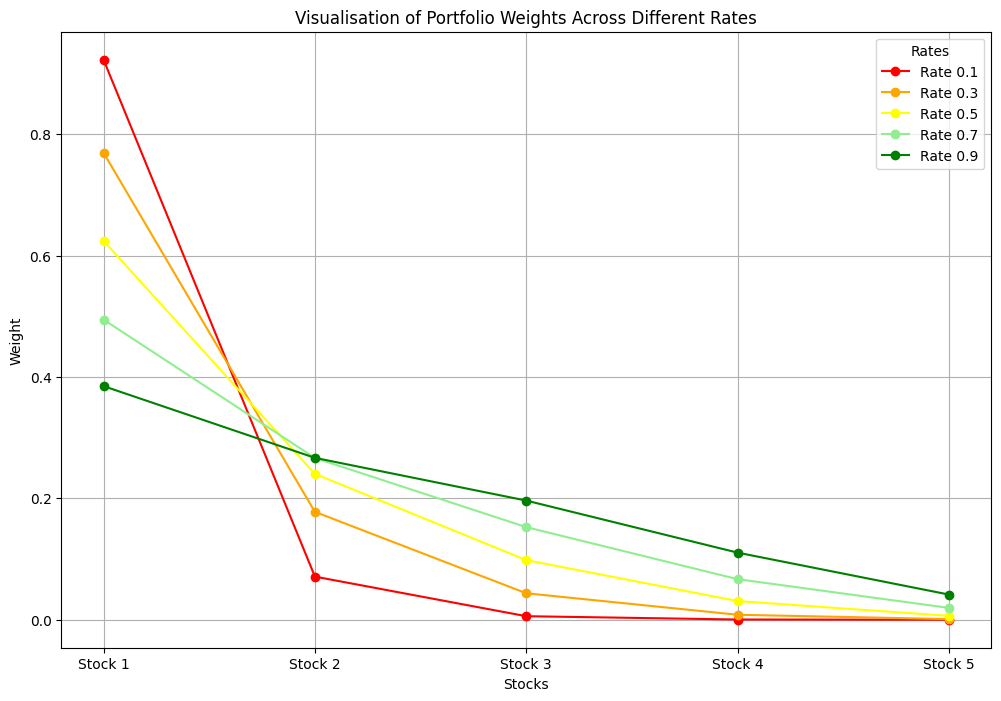

In [14]:
# Number of stocks
n_stocks = 5

# Simulate expected ROI for each stock
np.random.seed(42)  
expected_roi_per_stock = np.random.rand(n_stocks) * 10

# Sort so that Stock 1 has best ROI followed by Stock 2 and so on
expected_roi_per_stock = np.sort(expected_roi_per_stock)[::-1]

# Different rates to consider
rates = np.linspace(0.1, 0.9, 5)  # Example rates from 0.1 to 0.9

# Calculation of weights for each rate 
weights_by_rate = np.zeros((len(rates), n_stocks))
for i, rate in enumerate(rates):
    weights_by_rate[i] = portfolio_weights(rate, expected_roi_per_stock)[0]

# Define a color map from red to green through yellow
colors = ['red', 'orange', 'yellow', 'lightgreen', 'green']

# Plot each line for different rates with corresponding color
plt.figure(figsize=(12, 8))

stock_names = ['Stock ' + str(i+1) for i in range(n_stocks)]
for i, rate in enumerate(rates):
    plt.plot(stock_names, weights_by_rate[i], label=f'Rate {rate:.1f}', marker='o', color=colors[i])

plt.title('Visualisation of Portfolio Weights Across Different Rates')
plt.xlabel('Stocks')
plt.ylabel('Weight')
plt.legend(title='Rates')
plt.grid(True)

plt.show()

In [15]:
NUMBER_OF_RATE_TO_CONSIDER = 10

In [16]:
# Load the chosen model
model_path = f"{root_folder}/details/models/{MODEL_NAME}.h5"
model = tf.keras.models.load_model(model_path)

# Create the df which will be used to test several differet rates
data_to_create_portfolios = pd.DataFrame({
    "date": x_train.index.get_level_values(0),
    "stock": x_train.index.get_level_values(1),
    "current price": x_train_current_stock_prices,
    "true prices": y_train.values,
    "predicted prices": model.predict(x_train, batch_size=batch_size)[:, 0]
}).set_index("date")

# Convert to float
data_to_create_portfolios["predicted prices"] = data_to_create_portfolios["predicted prices"].astype("float")

# Sort values by 'date' and 'predicted prices' in ascending and descending order respectively
data_to_create_portfolios = data_to_create_portfolios.sort_values(by=["date", "predicted prices"], ascending=[True, False])

data_to_create_portfolios.head()

2968/2968 [==============================] - 5s 1ms/step


,stock,current price,true prices,predicted prices
date,,,,
1984-05-01,SPB,697.369995,254.830078,778.778381
1984-05-01,SEB,32.432625,56.171940,33.831245
1984-05-01,AIG,28.847786,41.687897,29.786133
1984-05-01,AVT,11.301846,9.180102,10.855029
1984-05-01,IBM,9.841852,11.062755,8.758124


In [17]:
# List of rates
rates = np.linspace(0, 1, NUMBER_OF_RATE_TO_CONSIDER + 1)[1:]
rates_rounded = np.round(rates, 3)  # Round rates to 3 decimal places

# Use multiprocessing to process the tasks in parallel
tasks = [(rate, data_to_create_portfolios) for rate in rates_rounded]
tasks_tqdm = tqdm(tasks, total=len(tasks), desc="Processing rates in parallel")
with Pool(os.cpu_count()) as p:
    results = p.map(rois_func, tasks_tqdm)

Processing rates in parallel:   0%|          | 0/10 [00:00<?, ?it/s]

In [18]:
# Create a dataframe from the results of all the rates tested
portfolio_rois_for_different_rates_df = pd.DataFrame(np.vstack(results), columns=["rate", "true ROI", "predicted ROI", "num unique stocks"])

# Drop nan rows as those represent times when all stocks were predicted to decrase in value
portfolio_rois_for_different_rates_df = portfolio_rois_for_different_rates_df.dropna()

# We are only going to invest when we predict a positive ROI so filter for instances where we predict positive ROI
positive_portfolio_rois_for_different_rates_df = portfolio_rois_for_different_rates_df.loc[portfolio_rois_for_different_rates_df["predicted ROI"]>0,:]
positive_portfolio_rois_for_different_rates_df.head()

,rate,true ROI,predicted ROI,num unique stocks
0,0.1,18.946583,1848.183106,51.0
1,0.1,19.240997,1844.809418,52.0
2,0.1,18.562312,1822.254452,51.0
3,0.1,20.351770,1831.659494,51.0
4,0.1,21.344338,1809.440871,51.0


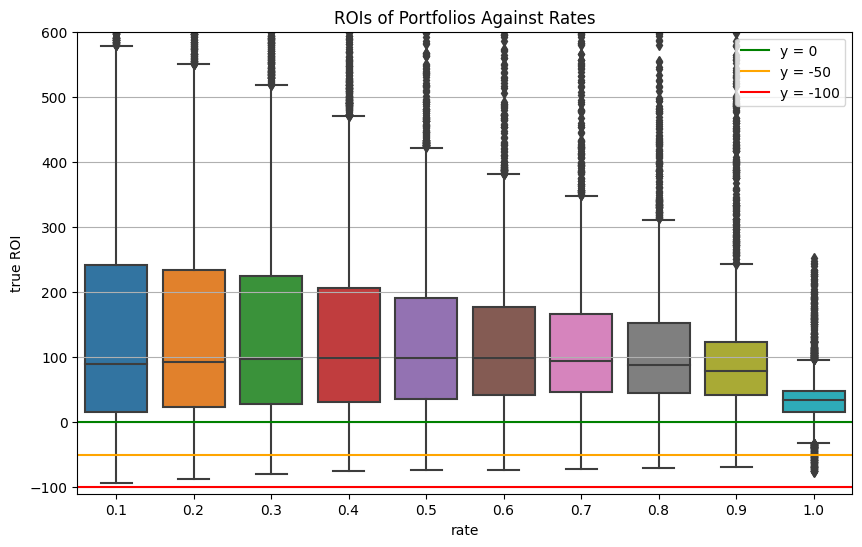

In [19]:
# Create a box plot using Seaborn
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='rate', y='true ROI', data=positive_portfolio_rois_for_different_rates_df)

# Add horizontal lines at specific y-values
ax.axhline(0, color='green', label='y = 0')
ax.axhline(-50, color='orange', label='y = -50')
ax.axhline(-100, color='red', label='y = -100')

# Set the initial y-axis range
ax.set_ylim(-110, 600)

# Adding title and legend
ax.set_title('ROIs of Portfolios Against Rates')
ax.legend(loc="upper right")

# Turn on grid lines
ax.grid(True, axis="y")

# Show plot
plt.show()

# Visualise Portfolios Created by the Best Model Using the Optimal Rate

In [20]:
# Choose the best rate based on the box plot above
best_rate = 0.6 # Chosen based on median ROI and worst ROI

In [21]:
# Create the df which will be used to test several differet rates
data_to_create_portfolios = pd.DataFrame({
    "date": model_data.iloc[:,:-1].index.get_level_values(0),
    "stock": model_data.iloc[:,:-1].index.get_level_values(1),
    "current price": current_stock_prices,
    "true prices": model_data.iloc[:,-1].values,
    "predicted prices": model.predict(model_data.iloc[:,:-1], batch_size=batch_size)[:, 0]
}).set_index("date")

# Convert to float
data_to_create_portfolios["predicted prices"] = data_to_create_portfolios["predicted prices"].astype("float")

# Sort values by 'date' and 'predicted prices' in ascending and descending order respectively
data_to_create_portfolios = data_to_create_portfolios.sort_values(by=["date", "predicted prices"], ascending=[True, False])

# Pre-calculate dataset string for each date
dataset_string_map = {date: "test" if date in test_dates else "val" if date in validation_dates else "train" for date in data_to_create_portfolios.index.unique()}

# Calculate expected ROI for each stock and update the df
data_to_create_portfolios["expected roi"] = ((data_to_create_portfolios["predicted prices"] - data_to_create_portfolios["current price"]) / data_to_create_portfolios["current price"]) * 100

# Sort values by 'date' and 'predicted prices' in ascending and descending order respectively
data_to_create_portfolios = data_to_create_portfolios.sort_values(by=["date", "expected roi"], ascending=[True, False])

# Create a portfolio for each date based on the predictions
portfolios_data = []
for date in tqdm(data_to_create_portfolios.index.unique(), desc="Getting portfolio rois"):
    # Get data for the current `date` we are creating portfolios on
    stock_data_for_current_date = data_to_create_portfolios.loc[date].copy()

    # Determine portfolio weights.
    weights, num_stocks = portfolio_weights(best_rate, stock_data_for_current_date["expected roi"])

    # Select top stocks to display when hovering over points
    top_stocks = stock_data_for_current_date.head(5)
    weights_string = ", ".join([str(round(w, 2)) for w in weights[:5]])
    stocks_string = ", ".join(top_stocks["stock"])
    current_prices_string = ", ".join(top_stocks["current price"].round(2).astype(str))
    predicted_prices_string = ", ".join(top_stocks["predicted prices"].round(2).astype(str))
    true_price_string = ", ".join(top_stocks["true prices"].round(2).astype(str))

    # Calculate portfolio wealth and ROIs.
    current_portfolio_wealth = sum([weights[w] * decimal.Decimal(stock_data_for_current_date["current price"][w]) for w in range(len(weights))])
    current_portfolio_wealth = float(current_portfolio_wealth)

    future_true_wealth = sum([weights[w] * decimal.Decimal(stock_data_for_current_date.loc[:, "true prices"][w]) for w in range(len(weights))])
    future_true_wealth = float(future_true_wealth)

    future_predicted_wealth = sum([weights[w] * decimal.Decimal(stock_data_for_current_date.loc[:, "predicted prices"][w]) for w in range(len(weights))])
    future_predicted_wealth = float(future_predicted_wealth)

    true_roi = ((future_true_wealth - current_portfolio_wealth) / current_portfolio_wealth) * 100 if current_portfolio_wealth != 0 else np.nan
    expected_roi = ((future_predicted_wealth - current_portfolio_wealth) / current_portfolio_wealth) * 100 if current_portfolio_wealth != 0 else np.nan

    # Append results directly to the DataFrame.
    portfolio_data = [true_roi, expected_roi, stocks_string, current_prices_string, true_price_string, predicted_prices_string, num_stocks, weights_string, dataset_string_map[date], str(date.date())]
    portfolios_data.append(portfolio_data)

# Convert to df
columns = ["true roi", 
           "expected roi", 
           "stocks", 
           "current stock prices", 
           "true prices after 365 working days", 
           "predicted prices after 365 working days", 
           "num unique stocks", 
           "weights", 
           "dataset", 
           "today's date"]
portfolios_data = pd.DataFrame(data=portfolios_data, columns=columns)

# Drop rows with NaN values in "true roi" and "expected roi", representing times when all stocks were expected to go down.
portfolios_data.dropna(subset=["true roi", "expected roi"], inplace=True)

# Change name as the apostrophe can cause issues
portfolios_data.rename(columns={"today's date": "current date"}, inplace=True)

portfolios_data.head()

4946/4946 [==============================] - 7s 1ms/step


Getting portfolio rois:   0%|          | 0/9618 [00:00<?, ?it/s]

,true roi,expected roi,stocks,current stock prices,true prices after 365 working days,predicted prices after 365 working days,num unique stocks,weights,dataset,current date
0,24.340849,1387.085069,"MO, DHR, BF.A, KR, MDT","0.09, 0.13, 0.18, 0.23, 0.29","0.1, 0.16, 0.25, 0.31, 0.35","1.72, 2.19, 1.79, 1.82, 2.12",51,"0.55, 0.27, 0.09, 0.04, 0.02",train,1984-05-01
1,23.138767,1388.884749,"MO, DHR, BF.A, KR, MDT","0.09, 0.13, 0.19, 0.23, 0.31","0.1, 0.15, 0.25, 0.31, 0.35","1.72, 2.19, 1.79, 1.82, 2.12",52,"0.55, 0.27, 0.09, 0.04, 0.02",train,1984-05-02
2,23.076059,1374.307216,"MO, DHR, BF.A, KR, MDT","0.09, 0.13, 0.19, 0.22, 0.3","0.1, 0.16, 0.25, 0.31, 0.35","1.72, 2.2, 1.79, 1.82, 2.12",51,"0.55, 0.27, 0.09, 0.05, 0.02",train,1984-05-03
3,23.069224,1373.285169,"MO, DHR, BF.A, KR, MDT","0.09, 0.14, 0.19, 0.22, 0.3","0.1, 0.15, 0.25, 0.31, 0.35","1.72, 2.2, 1.78, 1.82, 2.12",51,"0.55, 0.27, 0.09, 0.05, 0.02",train,1984-05-04
4,25.403984,1378.684847,"MO, DHR, BF.A, KR, MDT","0.09, 0.13, 0.18, 0.22, 0.29","0.11, 0.16, 0.25, 0.31, 0.36","1.72, 2.2, 1.78, 1.82, 2.12",51,"0.54, 0.28, 0.09, 0.05, 0.02",train,1984-05-07


In [22]:
# Remove all data for the validation set as this results in a plot which is too large
filtered_portfolios_data = portfolios_data[portfolios_data['dataset'] == 'test']

# Determine the percentage of profitable portfolios
test_rois_data = portfolios_data[portfolios_data['dataset'] == 'test']
profitable_portfolios = test_rois_data[test_rois_data["true roi"]>0].shape[0]/test_rois_data.shape[0]
print(f"{round(profitable_portfolios*100,2)}% profitable portfolios in the test set.")

# Filter for outliers to further reduce file size for upload to website
filtered_portfolios_data = filtered_portfolios_data[(filtered_portfolios_data['expected roi'] <= 1000) & 
                                (filtered_portfolios_data['true roi'] <= 1000)]

83.56% profitable portfolios in the test set.


In [23]:
# Custom hover data preparation
filtered_portfolios_data['hover_info'] = filtered_portfolios_data.apply(lambda row: 
    "<br>".join([
        f"<b>Stocks in Portfolio</b>: {row['stocks']}",
        f"<b>Current Prices</b>: {row['current stock prices']}",
        f"<b>True Prices after 1.5 years</b>: {row['true prices after 365 working days']}",
        f"<b>Predicted Prices after 1.5 years</b>: {row['predicted prices after 365 working days']}",
        f"<b>Weights</b>: {row['weights']}",
        "", 
        f"<b>True ROI</b>: {int(round(row['true roi'], 0))}%",
        f"<b>Predicted ROI</b>: {int(round(row['expected roi'], 0))}%",
        f"<b>Number of Unique Stocks in Portfolio: {row['num unique stocks']}</b>"
    ]), axis=1)

# Create interactive plot
fig = px.scatter(filtered_portfolios_data,
                 x="true roi", y="expected roi",
                 hover_data=["current date", "hover_info"],
                 marginal_x="box",
                 title="Expected return on investment (ROI) from portfolios against True ROI",
                 labels={"true roi": "True ROI (%)", "expected roi": "Expected ROI (%)"},
                 hover_name="current date")

# Customize hover template to display hover_info properly
fig.update_traces(hovertemplate='%{hovertext}<br>%{customdata[1]}')

# Remove hover text for boxplot due to storage constraints for uploading file to website
fig.data[1]["customdata"] = None
fig.data[1]["hovertext"] = None
fig.data[1]["hovertemplate"] = None

# Save the plot
fig.write_html(f"{root_folder}/best_model_portfolios.html")
print("Plot saved.")

Plot saved.


In [24]:
# Upload plots to display in website
import chart_studio
chart_studio.tools.set_credentials_file(username="nishandeep", api_key="gBO9G6t5lSB07IKO84SC")
import chart_studio.plotly as py


py.plot(loss_plot, filename="val loss against hyperparameters", auto_open=False)
py.plot(r_squared_plot, filename="r-squared loss against hyperparameters", auto_open=False)
py.plot(fig, filename="portfolios visualised", auto_open=False)

'https://plotly.com/~nishandeep/15/'

# Percentage of Profitable Portfolios Produced by the Best Baseline Model

In [25]:
# Load the best base-line model
MODEL_NAME = 73
model_path = f"{root_folder}/details/models/{MODEL_NAME}.h5"
model = tf.keras.models.load_model(model_path)

# Extract the hyperparameters
number_of_lines = model_hyperparameters['lines'].iloc[0]
number_of_years_to_consider = model_hyperparameters['years'].iloc[0]
batch_size =  model_hyperparameters['batch size'].iloc[0]

# Get the data 
model_data, current_stock_prices = prepare_model_data([], [], number_of_years_to_consider, number_of_lines)

# Split the data into 60% train set, 20% valudation set and 20% test set (the test data will be used in the following notebook.)
x_train, x_temp, y_train, y_temp = train_test_split(model_data.iloc[:,:-1], model_data.iloc[:,-1], test_size=0.4, random_state=42, shuffle=False)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

# Get current stock prices for the relevant datasets
x_train_current_stock_prices = train_test_split(current_stock_prices, test_size=0.4, random_state=42, shuffle=False)[0]

# Get date-time index
test_dates = x_test.index
validation_dates = x_val.index

# Create the df which will be used to test several differet rates
data_to_create_portfolios = pd.DataFrame({
    "date": model_data.iloc[:,:-1].index.get_level_values(0),
    "stock": model_data.iloc[:,:-1].index.get_level_values(1),
    "current price": current_stock_prices,
    "true prices": model_data.iloc[:,-1].values,
    "predicted prices": model.predict(model_data.iloc[:,:-1], batch_size=batch_size)[:, 0]
}).set_index("date")

# Convert to float
data_to_create_portfolios["predicted prices"] = data_to_create_portfolios["predicted prices"].astype("float")

# Sort values by 'date' and 'predicted prices' in ascending and descending order respectively
data_to_create_portfolios = data_to_create_portfolios.sort_values(by=["date", "predicted prices"], ascending=[True, False])

# Pre-calculate dataset string for each date
dataset_string_map = {date: "test" if date in test_dates else "val" if date in validation_dates else "train" for date in data_to_create_portfolios.index.unique()}

# Calculate expected ROI for each stock and update the df
data_to_create_portfolios["expected roi"] = ((data_to_create_portfolios["predicted prices"] - data_to_create_portfolios["current price"]) / data_to_create_portfolios["current price"]) * 100

# Sort values by 'date' and 'predicted prices' in ascending and descending order respectively
data_to_create_portfolios = data_to_create_portfolios.sort_values(by=["date", "expected roi"], ascending=[True, False])

# Create a portfolio for each date based on the predictions
portfolios_data = []
for date in tqdm(data_to_create_portfolios.index.unique(), desc="Getting portfolio rois"):
    # Get data for the current `date` we are creating portfolios on
    stock_data_for_current_date = data_to_create_portfolios.loc[date].copy()

    # Determine portfolio weights.
    weights, num_stocks = portfolio_weights(best_rate, stock_data_for_current_date["expected roi"])

    # Select top stocks to display when hovering over points
    top_stocks = stock_data_for_current_date.head(5)
    weights_string = ", ".join([str(round(w, 2)) for w in weights[:5]])
    stocks_string = ", ".join(top_stocks["stock"])
    current_prices_string = ", ".join(top_stocks["current price"].round(2).astype(str))
    predicted_prices_string = ", ".join(top_stocks["predicted prices"].round(2).astype(str))
    true_price_string = ", ".join(top_stocks["true prices"].round(2).astype(str))

    # Calculate portfolio wealth and ROIs.
    current_portfolio_wealth = sum([weights[w] * decimal.Decimal(stock_data_for_current_date["current price"][w]) for w in range(len(weights))])
    current_portfolio_wealth = float(current_portfolio_wealth)

    future_true_wealth = sum([weights[w] * decimal.Decimal(stock_data_for_current_date.loc[:, "true prices"][w]) for w in range(len(weights))])
    future_true_wealth = float(future_true_wealth)

    future_predicted_wealth = sum([weights[w] * decimal.Decimal(stock_data_for_current_date.loc[:, "predicted prices"][w]) for w in range(len(weights))])
    future_predicted_wealth = float(future_predicted_wealth)

    true_roi = ((future_true_wealth - current_portfolio_wealth) / current_portfolio_wealth) * 100 if current_portfolio_wealth != 0 else np.nan
    expected_roi = ((future_predicted_wealth - current_portfolio_wealth) / current_portfolio_wealth) * 100 if current_portfolio_wealth != 0 else np.nan

    # Append results directly to the DataFrame.
    portfolio_data = [true_roi, expected_roi, stocks_string, current_prices_string, true_price_string, predicted_prices_string, num_stocks, weights_string, dataset_string_map[date], str(date.date())]
    portfolios_data.append(portfolio_data)

# Convert to df
columns = ["true roi", 
           "expected roi", 
           "stocks", 
           "current stock prices", 
           "true prices after 365 working days", 
           "predicted prices after 365 working days", 
           "num unique stocks", 
           "weights", 
           "dataset", 
           "today's date"]
portfolios_data = pd.DataFrame(data=portfolios_data, columns=columns)

# Drop rows with NaN values in "true roi" and "expected roi", representing times when all stocks were expected to go down.
portfolios_data.dropna(subset=["true roi", "expected roi"], inplace=True)

# Change name as the apostrophe can cause issues
portfolios_data.rename(columns={"today's date": "current date"}, inplace=True)

portfolios_data.head()

Working on Dataset: 20 lines, 3 years:   0%|          | 0/9618 [00:00<?, ?it/s]

Number of features before PCA: 21
Number of features after PCA: 21
4946/4946 [==============================] - 5s 1ms/step


Getting portfolio rois:   0%|          | 0/9618 [00:00<?, ?it/s]

,true roi,expected roi,stocks,current stock prices,true prices after 365 working days,predicted prices after 365 working days,num unique stocks,weights,dataset,current date
0,23.125926,371.545439,"MO, DHR, BF.A, HUBB, WRB","0.09, 0.13, 0.18, 0.15, 0.2","0.1, 0.16, 0.25, 0.17, 0.31","0.54, 0.59, 0.7, 0.56, 0.61",117,"0.55, 0.22, 0.11, 0.06, 0.03",train,1984-05-01
1,22.528812,371.572321,"MO, DHR, BF.A, HUBB, WRB","0.09, 0.13, 0.19, 0.15, 0.2","0.1, 0.15, 0.25, 0.17, 0.31","0.54, 0.59, 0.7, 0.56, 0.62",116,"0.55, 0.22, 0.10, 0.06, 0.03",train,1984-05-02
2,22.221633,368.621229,"MO, DHR, BF.A, HUBB, WRB","0.09, 0.13, 0.19, 0.15, 0.2","0.1, 0.16, 0.25, 0.17, 0.31","0.54, 0.59, 0.7, 0.56, 0.63",117,"0.55, 0.22, 0.10, 0.06, 0.03",train,1984-05-03
3,22.957489,368.277037,"MO, DHR, BF.A, HUBB, WRB","0.09, 0.14, 0.19, 0.15, 0.2","0.1, 0.15, 0.25, 0.17, 0.31","0.54, 0.6, 0.7, 0.56, 0.63",117,"0.55, 0.22, 0.10, 0.06, 0.03",train,1984-05-04
4,24.745770,368.491216,"MO, DHR, BF.A, HUBB, WRB","0.09, 0.13, 0.18, 0.15, 0.2","0.11, 0.16, 0.25, 0.17, 0.31","0.54, 0.59, 0.69, 0.56, 0.64",118,"0.54, 0.22, 0.10, 0.06, 0.03",train,1984-05-07


In [26]:
# Determine the percentage of profitable portfolios
test_rois_data = portfolios_data[portfolios_data['dataset'] == 'test']
profitable_portfolios = test_rois_data[test_rois_data["true roi"]>0].shape[0]/test_rois_data.shape[0]
print(f"{round(profitable_portfolios*100,2)}% profitable portfolios in the test set.")

67.2% profitable portfolios in the test set.
